### Demo-02

STAC: 

'A spatiotemporal asset' is any file that represents information about the earth captured in a certain space and time.

'SpatioTemporal Asset Catalog' (STAC) specification provides a common structure for describing and cataloging spatiotemporal assets.

- STAC Item is the core atomic unit, representing a single spatiotemporal asset as a GeoJSON feature plus datetime and links.

- STAC Catalog is a simple, flexible JSON file of links that provides a structure to organize and browse STAC Items. A series of best practices helps make recommendations for creating real world STAC Catalogs.

- STAC Collection is an extension of the STAC Catalog with additional information such as the extents, license, keywords, providers, etc that describe STAC Items that fall within the Collection.

- STAC API provides a RESTful endpoint that enables search of STAC Items.

- Catalog -> Collection -> Item -> Asset

### Imports

In [60]:
import pystac_client
import planetary_computer
import geopandas as gpd
import pandas as pd
import contextily

In [61]:
import rasterio.features
import numpy as np
import xarray as xr
import stackstac
import xrspatial.multispectral as ms

import matplotlib.pyplot as plt

from shapely.geometry import Polygon

In [62]:
import dask_geopandas
import dask.distributed

#### Configure

Microsoft Planetary Computer STAC API:
https://planetarycomputer.microsoft.com/docs/reference/stac/

In [63]:
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

#### Initialise

In [64]:
#Catalog

#Initialise connection to Planetary Computer
catalog = pystac_client.Client.open(stac_url, 
                                   modifier=planetary_computer.sign_inplace)

In [65]:
#Get all collections
collections = catalog.get_collections()

list(collections)

[<CollectionClient id=daymet-annual-pr>,
 <CollectionClient id=daymet-daily-hi>,
 <CollectionClient id=3dep-seamless>,
 <CollectionClient id=3dep-lidar-dsm>,
 <CollectionClient id=fia>,
 <CollectionClient id=esa-worldcover>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=gridmet>,
 <CollectionClient id=daymet-annual-na>,
 <CollectionClient id=daymet-monthly-na>,
 <CollectionClient id=daymet-annual-hi>,
 <CollectionClient id=daymet-monthly-hi>,
 <CollectionClient id=daymet-monthly-pr>,
 <CollectionClient id=gnatsgo-tables>,
 <CollectionClient id=hgb>,
 <CollectionClient id=cop-dem-glo-30>,
 <CollectionClient id=cop-dem-glo-90>,
 <CollectionClient id=goes-cmi>,
 <CollectionClient id=terraclimate>,
 <CollectionClient id=nasa-nex-gddp-cmip6>,
 <CollectionClient id=gpm-imerg-hhr>,
 <CollectionClient id=io-lulc-9-class>,
 <CollectionClient id=gnatsgo-rasters>,
 <CollectionClient id=3dep-lidar-hag>,
 <CollectionClient id=3dep-lidar-intensity>,
 <CollectionClient id=3dep-lidar-po

MS Buildings Dataset:
Open building footprints around the world, over 999 million buildings from Bing Maps imagery.

In [66]:
#Collection = ms-buildings
msb = catalog.get_collection("ms-buildings")
msb

<CollectionClient id=ms-buildings>

In [67]:
#Get item list within the collection
list(msb.get_all_items())

[<Item id=United States_2022-07-06>,
 <Item id=United Kingdom_2022-07-06>,
 <Item id=Timor-Leste_2022-07-06>,
 <Item id=Switzerland_2022-07-06>,
 <Item id=Singapore_2022-07-06>,
 <Item id=Philippines_2022-07-06>,
 <Item id=Papua New Guinea_2022-07-06>,
 <Item id=Oceania_2022-07-06>,
 <Item id=Nigeria_2022-07-06>,
 <Item id=Netherlands_2022-07-06>,
 <Item id=Malaysia_2022-07-06>,
 <Item id=Luxembourg_2022-07-06>,
 <Item id=Kenya_2022-07-06>,
 <Item id=Isle of Man_2022-07-06>,
 <Item id=Ireland_2022-07-06>,
 <Item id=Indonesia_2022-07-06>,
 <Item id=Czechia_2022-07-06>,
 <Item id=Canada_2022-07-06>,
 <Item id=Brunei_2022-07-06>,
 <Item id=Belgium_2022-07-06>,
 <Item id=Australia_2022-07-06>,
 <Item id=United States_2022-06-14>,
 <Item id=Timor-Leste_2022-06-14>,
 <Item id=Singapore_2022-06-14>,
 <Item id=Philippines_2022-06-14>,
 <Item id=Papua New Guinea_2022-06-14>,
 <Item id=Oceania_2022-06-14>,
 <Item id=Nigeria_2022-06-14>,
 <Item id=Malaysia_2022-06-14>,
 <Item id=Kenya_2022-06-14>

In [68]:
#Get details of a particular item
msb_item = msb.get_item(id='Australia_2022-06-14')
msb_item

<Item id=Australia_2022-06-14>

In [69]:
#Review asset
msb_asset = msb_item.assets["data"]
msb_asset

<Asset href=abfs://footprints/global/2022-06-14/ml-buildings.parquet/RegionName=Australia>

#### Catalog Search

In [70]:
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": "Vatican City"}}
)
item = next(items.items())
item

<Item id=Vatican City_2022-07-06>

In [73]:
asset.href
asset.extra_fields["table:storage_options"]

{'account_name': 'bingmlbuildings',
 'credential': 'st=2023-02-13T02%3A58%3A27Z&se=2023-02-14T03%3A43%3A27Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-02-09T02%3A29%3A54Z&ske=2023-02-16T02%3A29%3A54Z&sks=b&skv=2021-06-08&sig=/roodF0nmnBVP6WQMES3e%2BiCpuHWzVY90sWnyAdBcB4%3D'}

In [71]:
asset = item.assets["data"]

msb_vatican_df = gpd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
msb_vatican_df.head()

geometry    quadkey
0  POLYGON ((12.45281 41.90667, 12.45270 41.90667...  120232221
1  POLYGON ((12.45628 41.90528, 12.45625 41.90467...  120232221
2  POLYGON ((12.45183 41.90168, 12.45199 41.90172...  120232221
3  POLYGON ((12.45091 41.90227, 12.45095 41.90249...  120232221
4  POLYGON ((12.44829 41.90253, 12.44824 41.90256...  120232221

In [74]:
msb_vatican_df.shape

(91, 2)

https://contextily.readthedocs.io/en/latest/intro_guide.html

In [ ]:
# contextily.providers

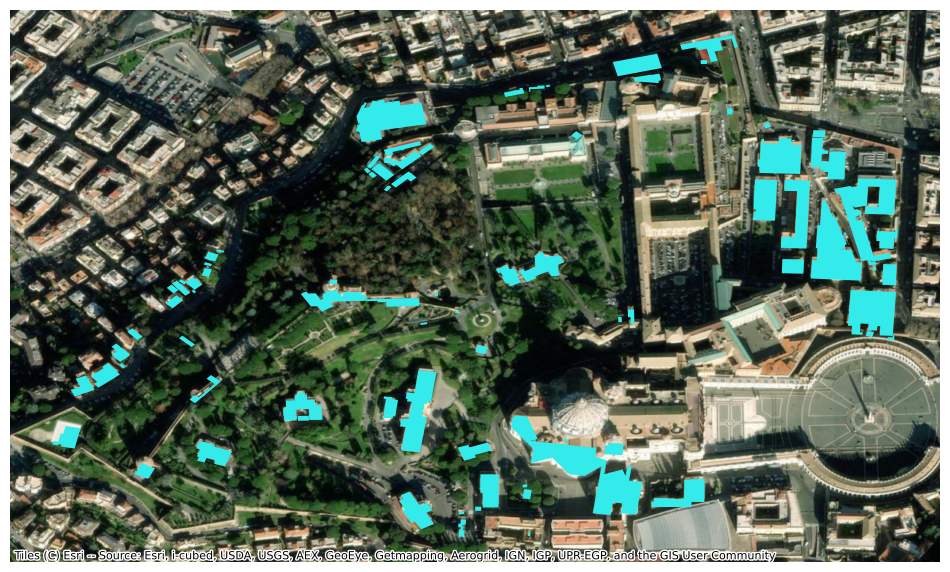

In [75]:
#Plot on map
ax = msb_vatican_df.plot(figsize=(12, 12), color="#34ebeb")
contextily.add_basemap(
    ax, 
    # source=contextily.providers.Stamen.TonerLite, 
    source=contextily.providers.Esri.WorldImagery,
    crs=msb_vatican_df.crs.to_string()
)
ax.set_axis_off()

#### Read the dataset 
Planetary Computer, Australia Region

In [76]:
items = catalog.search(
    collections=["ms-buildings"], 
    datetime="2020-01-01/2022-07-30",
    query={"msbuildings:region": {"eq": "Singapore"}},    
)

item = next(items.items())
item

<Item id=Singapore_2022-07-06>

In [77]:
asset = item.assets["data"]

In [78]:
asset.href

'abfs://footprints/global/2022-07-06/ml-buildings.parquet/RegionName=Singapore'

In [79]:
asset.extra_fields["table:storage_options"]

{'account_name': 'bingmlbuildings',
 'credential': 'st=2023-02-13T02%3A58%3A27Z&se=2023-02-14T03%3A43%3A27Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-02-09T02%3A29%3A54Z&ske=2023-02-16T02%3A29%3A54Z&sks=b&skv=2021-06-08&sig=/roodF0nmnBVP6WQMES3e%2BiCpuHWzVY90sWnyAdBcB4%3D'}

In [80]:
msb_singapore_df = gpd.read_parquet(
    asset.href,     
    storage_options=asset.extra_fields["table:storage_options"]
)

msb_singapore_df.head()

geometry    quadkey
0  POLYGON ((103.77059 1.42300, 103.77060 1.42304...  132232213
1  POLYGON ((103.79219 1.42619, 103.79227 1.42616...  132232213
2  POLYGON ((103.84774 1.41721, 103.84768 1.41721...  132232213
3  POLYGON ((103.84774 1.41728, 103.84775 1.41723...  132232213
4  POLYGON ((103.79933 1.43452, 103.79927 1.43452...  132232213

In [81]:
msb_singapore_df.shape

(125315, 2)

In [82]:
msb_singapore_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125315 entries, 0 to 125314
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  125315 non-null  geometry
 1   quadkey   125315 non-null  category
dtypes: category(1), geometry(1)
memory usage: 1.1 MB


Plot the dataset

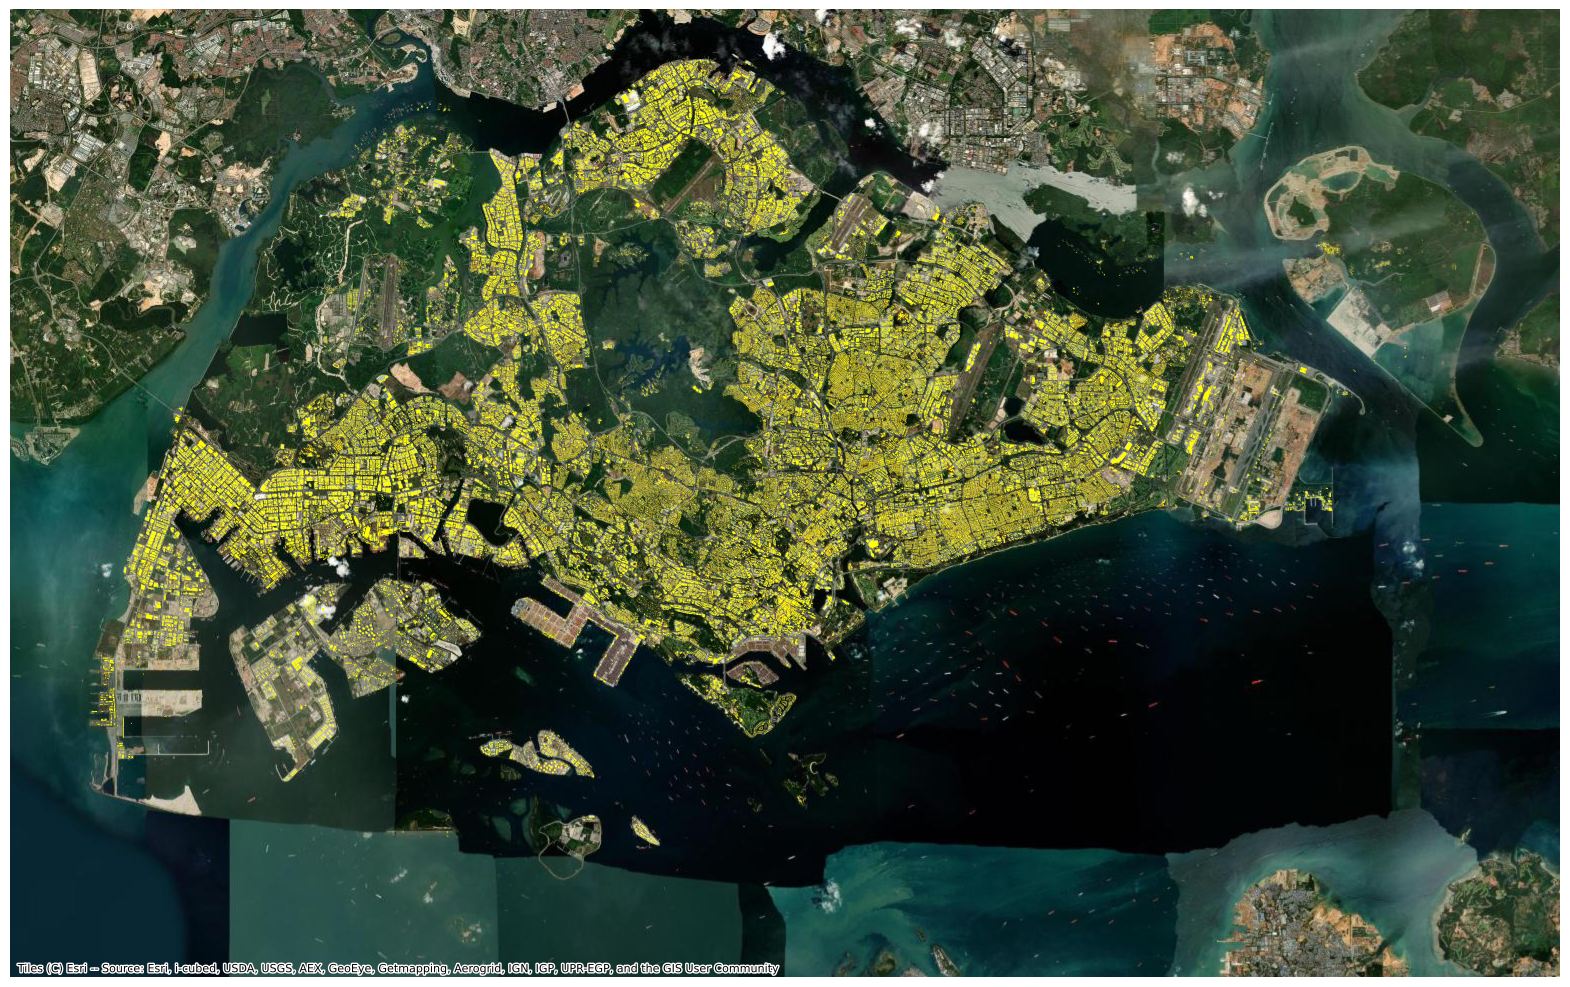

In [83]:
ax = msb_singapore_df[['geometry']].plot(figsize=(20, 20), color="#ffff00")

contextily.add_basemap(
    ax,       
    source=contextily.providers.Esri.WorldImagery,    
    crs=(msb_singapore_df[['geometry']]).crs.to_string()    
)
ax.set_axis_off()

#### Working with bigger datasets

https://distributed.dask.org/en/stable/api.html#distributed.Client

In [ ]:
# client = dask.distributed.Client(n_workers=6)
# client.close() #To close cluster

In [ ]:
# print(client)
# print(client.dashboard_link)

Scale with Dask

https://github.com/microsoft/PlanetaryComputerExamples/blob/f59a5628ed5a7ce2f5baa8cc295be6df5b2aec05/quickstarts/scale-with-dask.ipynb